In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score
# do ostatecznej selekcji zmiennych
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix,classification_report

from optbinning import BinningProcess,OptimalBinning,Scorecard  # kombajn do bucket'owania i scorecard
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks

import statsmodels.api as sd #statystyki dla modeli - tylko bez pipeline sklearn
import shap

#from lightgbm import LGBMClassifier #!pip install lightgbm
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, partial

import warnings
warnings.simplefilter("ignore")

import pickle

d:\02_venv\gb1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
d:\02_venv\gb1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


##### Funkcje do metryk

In [1]:
def create_measures(y,y_pred): 
    score_test = roc_auc_score(y, y_pred)
    Gini_index = 2*score_test - 1
     
    d = {'AUC': [round(score_test,4)], 'GINI': [round(Gini_index,4)]}
    d = pd.DataFrame.from_dict(d)
    return d


def create_measures2(y,y_pred): 
    score_test = roc_auc_score(y, y_pred)
    auc = score_test
    gini = 2*score_test - 1

    y_pred_class=np.where(y_pred>0.5,1,0)
    cm = confusion_matrix(y, y_pred_class)    
    TP, FN, FP, TN =cm.ravel()

    P=TP+FN #actual positive
    N=FP+TN # acutal negative
    PP=TP+FP #predicted positive
    PN=FN+TN #predicted negative
    
    recall = TP/P #recall,sensitivity, hit rate
    precision = TP/PP #precision
    
    f1_score=2*TP/(2*TP+FP+FN)
    accuracy=(TP+TN)/(P+N)
    balanced_accuracy=(TPR+TNR)/2    
    
    return auc, gini, accuracy, balanced_accuracy, f1_score, recall, precision


 
def calculating_metrics(X_train, X_test, X_oot, y_train, y_test, y_oot,model):
    train = create_measures(y_train,model.predict_proba(X_train)[:, 1])
    test = create_measures(y_test,model.predict_proba(X_test)[:, 1])
    oot = create_measures(y_oot,model.predict_proba(X_oot)[:, 1]) 
 
    measures =  pd.concat([train,test,oot]).set_index([pd.Index(['TRAIN', 'TEST', 'OOT'])]) 
     
    return measures

# def pd_to_score(df, pd_column, classification_type='bin'):
#     df[pd_column]=np.where(df[pd_column]<0.9999,df[pd_column],0.9999)
#     df[pd_column]=np.where(df[pd_column]>0.0001,df[pd_column],0.0001)   
#     df[pd_column]=np.round(df[pd_column],4)
#     #df['score']=np.round(np.log((1/w-1)+2.7)*85+216 ,0).astype(int)
#     df['score']=np.round(np.log((1/df[pd_column]-1)+7)*60 ,0).astype(int)
    
def pd_to_score2(df, pd_column, offset_start, PD_start,PDO=50 ):
    df[pd_column]=np.where(df[pd_column]<0.9999,df[pd_column],0.9999)
    df[pd_column]=np.where(df[pd_column]>0.0001,df[pd_column],0.0001)
    df[pd_column]=np.round(df[pd_column],4)
    
    odds=(1-PD_start)/PD_start
    log_odds=np.log(odds)
    factor=PDO/np.log(2)  # z '-' wtedy najgorszy ma najwiekszego skora
    offset=offset_start-factor*log_odds

    df['score']=np.round(np.log((1/df[pd_column]-1))*factor+offset ,0).astype(int)
    score_min=round(offset_start-factor*np.log(odds)+factor*np.log(1/9999),0)
    score_max=round(offset_start-factor*np.log(odds)+factor*np.log(9999),0)
    print('score min: {0}, score max: {1}'.format(score_min,score_max))
    return score_min, score_max

In [4]:
def objective(space):
    xgb_params = {
        # ogólne
        'learning_rate': space['learning_rate'],
        'max_depth': int(space['max_depth']),
        'n_estimators': int(space['n_estimators']),
        'min_child_weight': int(space['min_child_weight']),
        'gamma': space['gamma'],
        'seed': space['seed'], 
        # do walki z overfiting
        'subsample': space['subsample'],
        'colsample_bytree': space['colsample_bytree'],
        'colsample_bylevel': space['colsample_bylevel'],
        'max_delta_step': 0,
        # regularyzacja
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'scale_pos_weight':space['scale_pos_weight'],
        # pozostałe
        'metric': 'auc',  
        'eval_metric': 'auc', 
        'tree_method': 'gpu_hist',
        'objective':'binary:logistic',
        'booster': 'gbtree'
    }
 
    model = XGBClassifier(**xgb_params,verbosity = 0)
    model.fit(X_train, y_train)
    y_test_pred = model.predict_proba(X_test)[:, 1]
    y_train_pred = model.predict_proba(X_train)[:, 1]
    score = - roc_auc_score(y_test, y_test_pred) #to będę minimalizował
    BS_results.append([roc_auc_score(y_test, y_test_pred),roc_auc_score(y_train, y_train_pred), xgb_params])
    #print("{0}. Score: test-> {1:.4} , train-> {2:.4} ".format(len(BS_results),roc_auc_score(y_test, y_test_pred),roc_auc_score(y_train, y_train_pred)))
    print(f"{len(BS_results):5}. (train, test) GINI: ({2*roc_auc_score(y_train, y_train_pred)-1: 7.2%},{2*roc_auc_score(y_test, y_test_pred)-1: 7.2%}) ")
     
    return{'loss':score, 'status': STATUS_OK }

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix2(cf, title=None):

    group_labels = ['TRUE POSITIVE (TP) \nhit\n',
                    'FALSE NEGATIVE (FN) \n[type 2 error] \nmiss \nunderestimation\n',
                    'FALSE POSITIVE (FP) \n[type 1 error] \nfalse alarm \noverstimation\n',
                    'TRUE NEGATIVE (TN) \ncorrect rejection\n']
    xcategories = ['Positive (PP)', 'Negative (PN)']
    ycategories = ['Positive (P)', 'Negative (N)']
    group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    
    TP, FN, FP, TN =cf.ravel()
    P=TP+FN #actual positive
    N=FP+TN # acutal negative
    PP=TP+FP #predicted positive
    PN=FN+TN #predicted negative
    
    TPR=TP/P #recall,sensitivity, hit rate
    FNR=FN/P #miss rate
    FPR=FP/N #false alarm proba, fall-out
    TNR=TN/N #specifity, selevtivity
    
    PPV=TP/PP #precision
    FOR=FN/PN 
    FDR=FP/PP
    NPV=TN/PN

    F1_score=2*TP/(2*TP+FP+FN)
    Accuracy=(TP+TN)/(P+N)
    Balanced_Accuracy=(TPR+TNR)/2
    


    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
    
    stats_text = """\n\nAccuracy: {:23.2%}\nBalanced Accuracy: {:7.2%}\n\nF1 Score: {:23.2%}\nPrecision: {:22.2%}\nRecall: {:27.2%}""".format(Accuracy,Balanced_Accuracy,F1_score,PPV,TPR)

    group_labels2 = ['True positive rate (TPR) \nRECALL, sensitivity\nTPR = TP / P\n',
                     'False negative rate (FNR) \nmiss rate \nFNR = FN / P\n',
                     'False positive rate (FPR) \nFALLOUT, false alarm proba\nFPR = FP / N\n',
                     'True negative rate (TNR) \nspecificity\nTNR = TN / N\n']
    group_counts2 = ["{0:0.2%}\n".format(value) for value in [TPR,FNR,FPR,TNR]]
    box_labels2 = [f"{v1}{v2}".strip() for v1, v2 in zip(group_labels2,group_counts2)]
    box_labels2 = np.asarray(box_labels2).reshape(cf.shape[0],cf.shape[1])    
    
    group_labels3 = ['Positive predictive value (PPV) \nPRECISION \nPPV = TP / PP\n',
                     'False omission rate (FOR) \nFOR = FN / PN\n',
                     'False discovery rate (FDR) \nFDR = FP / PP\n',
                     'Negative predictive value (NPV)  \nNPV = TN / PN\n']
    group_counts3 = ["{0:0.2%}\n".format(value) for value in [PPV,FOR,FDR,NPV]]
    box_labels3 = [f"{v1}{v2}".strip() for v1, v2 in zip(group_labels3,group_counts3)]
    box_labels3 = np.asarray(box_labels3).reshape(cf.shape[0],cf.shape[1])              

    df = pd.DataFrame({'Straight': [i for i in range(10)],'Square': [i * i for i in range(10)]})    
    plt.rcParams["figure.figsize"] = [11, 7]
    plt.rcParams["figure.autolayout"] = True
    
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    g1=sns.heatmap(cf,annot=box_labels,fmt="",cmap='Blues',cbar=True,xticklabels=xcategories,yticklabels=ycategories,ax=ax1)
    g1.set_ylabel('ACTUAL')
    g1.set_xlabel('PREDICTED')
    g1.set_title('Confiusion matrix') 
    ax2 = fig.add_subplot(2,2,2)
    ax2.text(0.25, 0.4, stats_text, fontsize=16)
    ax2.axis('off')

    ax3 = fig.add_subplot(2,2,3)  
    metrics1=pd.DataFrame({'col1': [10,0], 'col2': [0,10]})
    g3=sns.heatmap(metrics1,annot=box_labels2,fmt="",cmap='RdYlGn',cbar=False,xticklabels=xcategories,yticklabels=ycategories,ax=ax3)
    g3.set_ylabel('ACTUAL')
    g3.set_xlabel('PREDICTED')    
    g3.set_title('Metrics') 
    ax4 = fig.add_subplot(2,2,4)  
    metrics1=pd.DataFrame({'col1': [10,0], 'col2': [0,10]})
    g4=sns.heatmap(metrics1,annot=box_labels3,fmt="",cmap='RdYlGn',cbar=False,xticklabels=xcategories,yticklabels=ycategories,ax=ax4)
    g4.set_ylabel('ACTUAL')
    g4.set_xlabel('PREDICTED')       
    plt.show()

##### Zbiór danych

In [6]:
# Wykorzystywane od punktu 3.1 do zabawy binning i modelami
uci_credit_card= pd.read_csv('data/UCI_Credit_Card.csv')
uci_credit_card_target=uci_credit_card.columns[-1]
uci_credit_card_features=uci_credit_card.columns[1:6]  #[1:-1]
uci_credit_card_features=uci_credit_card.columns[1:-1]

In [7]:
X=uci_credit_card.loc[:,uci_credit_card_features]
y=uci_credit_card.loc[:,uci_credit_card_target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=112)

In [8]:
X=uci_credit_card.loc[:,uci_credit_card_features]
y=uci_credit_card.loc[:,uci_credit_card_target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2019)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=2019)
 
print('TRAIN:',X_train.shape, y_train.shape)
print('TEST:',X_test.shape, y_test.shape)
print('VALIDATION:',X_val.shape, y_val.shape)

TRAIN: (18000, 23) (18000,)
TEST: (6000, 23) (6000,)
VALIDATION: (6000, 23) (6000,)


##### xgb surowy

In [9]:
xgbR=XGBClassifier(random_state=112
                  , max_depth=4
                  , min_child_weight=10
                  , n_estimators=50
                  , learning_rate=0.15
                  , eval_metric='auc'
                  , objective='binary:logistic'
                  ,booster= 'gbtree' # gbtree gblinear  dart.

                 )
xgbR.fit(X_train, y_train)

xgbR_y_train_pred = xgbR.predict_proba(X_train)[:, 1]
xgbR_y_test_pred = xgbR.predict_proba(X_test)[:, 1]
auc_train= round(roc_auc_score(y_train, xgbR_y_train_pred),4) 
auc_test= round(roc_auc_score(y_test, xgbR_y_test_pred),4) 

#display({'auc_train': auc_train, 'auc_test': auc_test})
#display({'gini_train': round(auc_train*2-1,4), 'gini_test': round(auc_test*2-1,4)})

measures = calculating_metrics(X_train, X_test, X_val, y_train, y_test, y_val,xgbR)
measures

AUC    GINI
TRAIN  0.8114  0.6228
TEST   0.7877  0.5754
OOT    0.7910  0.5820

##### Parametry

In [10]:
params_range_0 ={ #wlasne
    'learning_rate': hp.uniform ('learning_rate', 0.01, 0.5),
    'max_depth': hp.quniform ('max_depth', 4, 10, 1),
    'n_estimators': hp.quniform ('n_estimators', 50, 400, 50),
    'min_child_weight': hp.quniform ('min_child_weight', 5, 100, 5),
    'gamma': hp.loguniform ('gamma', 1.0, 9.0),
    'seed':112,
    'subsample': hp.uniform ('subsample', 0.5, 1.0),    
    'colsample_bytree': hp.uniform ('colsample_bytree', 0.5, 1.0),
    'colsample_bylevel': hp.uniform ('colsample_bylevel', 0.5, 1.0),
    'reg_alpha': hp.loguniform ('reg_alpha', 0.0, 9.0),
    'reg_lambda': hp.loguniform ('reg_lambda', 0.0, 9.0),
    'scale_pos_weight': hp.quniform ('scale_pos_weight', 1.0, 11.0, 1)
}

###### alternatywne parametry

In [1]:
params_start_1 ={ #A
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 300,
    'min_child_weight':40,
    'gamma': 5,
    'seed': 112,
    #wpływ na overfitting
    'subsample': 1,    
    'colsample_bytree': 1,
    'colsample_bylevel':1,
    'max_delta_step':0,
    # regularyzacja:
    'reg_alpha': 7,
    'reg_lambda': 3,
    #pozostałe
    'metric':'auc',
    'eval_metric':'auc',
    'n_jobs':4,
    'scale_pos_weight':1, #zachowanie balansu pomiędzy positive i negative (użyteczne dla danych niezbilansowanych)
    'tree_method': 'gpu_hist',
    'objective':'binary:logistic'
    #'booster': 'gbtree'
}

In [ ]:
params_start_2 ={ #M
    'learning_rate': 0.6,
    'max_depth': 9,
    'n_estimators': 600,
    'min_child_weight':5,
    'gamma': 5,
    'seed': 112,
    #wpływ na overfitting
    'subsample': 0.78,    
    'colsample_bytree': 0.94,
    'colsample_bylevel': 1,
    # regularyzacja:
    'reg_alpha': 7,
    'reg_lambda': 3,
    #pozostałe
    'metric':'auc',
    'eval_metric':'auc',
    'n_jobs':4,
    'scale_pos_weight':1 #zachowanie balansu pomiędzy positive i negative (użyteczne dla danych niezbilansowanych)
}

In [9]:
params_range_1 ={ #Ada
    'learning_rate': hp.uniform ('learning_rate', 0.05, 0.3),
    'max_depth': hp.quniform ('max_depth', 5, 8, 1),
    'n_estimators': hp.quniform ('n_estimators', 100, 200, 20),
    'min_child_weight': hp.quniform ('min_child_weight', 20, 100, 5),
    'gamma': hp.loguniform ('gamma', 1.0, 9.0),
    'seed':112,
    'subsample': hp.uniform ('subsample', 0.5, 1.0),    
    'colsample_bytree': hp.uniform ('colsample_bytree', 0.5, 1.0),
    'colsample_bylevel': hp.uniform ('colsample_bylevel', 0.5, 1.0),
    'reg_alpha': hp.loguniform ('reg_alpha', 0.0, 9.0),
    'reg_lambda': hp.loguniform ('reg_lambda', 0.0, 9.0),
    'scale_pos_weight': hp.quniform ('scale_pos_weight', 1.0, 11.0, 1)
}

In [10]:
params_range_2 ={ #Maciek
    'learning_rate': hp.uniform ('learning_rate', 0.05, 0.3),
    'max_depth': hp.quniform ('max_depth', 5, 8, 1),
    'n_estimators': hp.quniform ('n_estimators', 100, 300, 100),
    'min_child_weight': hp.quniform ('min_child_weight', 20, 100, 5),
    'gamma': hp.loguniform ('gamma', 1.0, 9.0),
    'seed':112,
    'subsample': hp.uniform ('subsample', 0.5, 1.0),    
    'colsample_bytree': hp.uniform ('colsample_bytree', 0.5, 1.0),
    'colsample_bylevel': hp.uniform ('colsample_bylevel', 0.5, 1.0),
    'reg_alpha': hp.loguniform ('reg_alpha', 0.0, 9.0),
    'reg_lambda': hp.loguniform ('reg_lambda', 0.0, 9.0),
    'scale_pos_weight': hp.quniform ('scale_pos_weight', 1.0, 11.0, 1)
}

In [11]:
params_range_3 ={ #Mirek
    'learning_rate': hp.loguniform ('learning_rate', 0.01, 0.5),
    'max_depth': hp.quniform ('max_depth', 1, 9, 1),
    'n_estimators': hp.quniform ('n_estimators', 100, 1000, 50),
    'min_child_weight': hp.quniform ('min_child_weight', 0, 100, 1),
    'gamma': hp.loguniform ('gamma', 0.0, 2.0),
    'seed':112,
    'subsample': hp.uniform ('subsample', 0.5, 1.0),    
    'colsample_bytree': hp.uniform ('colsample_bytree', 0.5, 1.0),
    'colsample_bylevel': hp.uniform ('colsample_bylevel', 0.5, 1.0),
    'reg_alpha': hp.loguniform ('reg_alpha', 0.0, 2.0),
    'reg_lambda': hp.loguniform ('reg_lambda', 0.0, 2.0),
    'scale_pos_weight': hp.quniform ('scale_pos_weight', 1.0, 11.0, 1)
}

##### Optymalizacja parametrów

In [11]:
# parametr mówiący ile iteracji najpierw losujemy zanim zaczniemy optymalizować parametry
n_startup_jobs = 48 # liczba całkowita > 0
 
# parametr ile łącznie robimy iteracji 
max_evals = 4*4*4*2 # liczba całkowita > n_startup_jobs
 
BS_results = []

trials = Trials()
best_params = fmin(fn=objective,
                   space=params_range_0,
                   algo=partial(tpe.suggest, n_startup_jobs=n_startup_jobs),
                   max_evals=max_evals,
                   trials=trials)
 
print("The best params: ", best_params)

    1. GINI: test->   0.00% , train->   0.00%                                                                          
    2. GINI: test->  40.59% , train->  36.14%                                                                          
    3. GINI: test->  43.21% , train->  38.73%                                                                          
    4. GINI: test->   0.00% , train->   0.00%                                                                          
    5. GINI: test->  54.55% , train->  51.15%                                                                          
    6. GINI: test->   0.00% , train->   0.00%                                                                          
    7. GINI: test->  55.83% , train->  54.32%                                                                          
    8. GINI: test->   0.00% , train->   0.00%                                                                          
    9. GINI: test->  57.20% , train->  5

In [12]:
#plt.plot(pd.DataFrame(BS_results).iloc[:,0:2])
display(pd.DataFrame(BS_results,columns=['test','train','param']).iloc[:,0:3].sort_values(by=['test']))
display(pd.DataFrame(pd.DataFrame(BS_results,columns=['test','train','param']).iloc[:,0:3].sort_values(by=['test']).tail(1)).iloc[:,-1].tolist())

test     train                                              param
0    0.500000  0.500000  {'learning_rate': 0.32377528369669684, 'max_de...
23   0.500000  0.500000  {'learning_rate': 0.369481615032343, 'max_dept...
13   0.500000  0.500000  {'learning_rate': 0.11419858448167376, 'max_de...
95   0.500000  0.500000  {'learning_rate': 0.26506680555728274, 'max_de...
24   0.500000  0.500000  {'learning_rate': 0.1427028882178433, 'max_dep...
..        ...       ...                                                ...
100  0.788751  0.787414  {'learning_rate': 0.22671609343003984, 'max_de...
42   0.788902  0.790115  {'learning_rate': 0.34214577742848906, 'max_de...
115  0.789227  0.786927  {'learning_rate': 0.41029863566995917, 'max_de...
74   0.789415  0.782757  {'learning_rate': 0.3738301623234227, 'max_dep...
53   0.789481  0.793322  {'learning_rate': 0.3416382877793446, 'max_dep...

[128 rows x 3 columns]

[{'learning_rate': 0.3416382877793446,
  'max_depth': 5,
  'n_estimators': 300,
  'min_child_weight': 60,
  'gamma': 2.7940468454486944,
  'seed': 112,
  'subsample': 0.8243413478278171,
  'colsample_bytree': 0.9909955232467921,
  'colsample_bylevel': 0.7624485191192751,
  'max_delta_step': 0,
  'reg_alpha': 88.57535133982567,
  'reg_lambda': 130.11120513651485,
  'scale_pos_weight': 6.0,
  'metric': 'auc',
  'eval_metric': 'auc',
  'tree_method': 'gpu_hist',
  'objective': 'binary:logistic',
  'booster': 'gbtree'}]

##### best model

In [13]:
display(best_params)
params_final={'colsample_bylevel': best_params['colsample_bylevel'],
 'colsample_bytree': best_params['colsample_bytree'],
 'gamma': best_params['gamma'],
 'learning_rate': best_params['learning_rate'],
 'max_depth': best_params['max_depth'].astype(int),
 'min_child_weight':  best_params['min_child_weight'].astype(int),
 'n_estimators':  best_params['n_estimators'].astype(int),
 'reg_alpha': best_params['reg_alpha'],
 'reg_lambda': best_params['reg_lambda'],
 'scale_pos_weight': best_params['scale_pos_weight'],
 'subsample':best_params['subsample'],
 'seed':112,
 'metric': 'auc',  
 'eval_metric': 'auc', 
 'tree_method': 'gpu_hist',
 'objective':'binary:logistic',
 'booster': 'gbtree'
  }
display(params_final)

{'colsample_bylevel': 0.7624485191192751,
 'colsample_bytree': 0.9909955232467921,
 'gamma': 2.7940468454486944,
 'learning_rate': 0.3416382877793446,
 'max_depth': 5.0,
 'min_child_weight': 60.0,
 'n_estimators': 300.0,
 'reg_alpha': 88.57535133982567,
 'reg_lambda': 130.11120513651485,
 'scale_pos_weight': 6.0,
 'subsample': 0.8243413478278171}

{'colsample_bylevel': 0.7624485191192751,
 'colsample_bytree': 0.9909955232467921,
 'gamma': 2.7940468454486944,
 'learning_rate': 0.3416382877793446,
 'max_depth': 5,
 'min_child_weight': 60,
 'n_estimators': 300,
 'reg_alpha': 88.57535133982567,
 'reg_lambda': 130.11120513651485,
 'scale_pos_weight': 6.0,
 'subsample': 0.8243413478278171,
 'seed': 112,
 'metric': 'auc',
 'eval_metric': 'auc',
 'tree_method': 'gpu_hist',
 'objective': 'binary:logistic',
 'booster': 'gbtree'}

In [26]:
xgbBest = XGBClassifier(**params_final)
xgbBest.fit(X_train, y_train,early_stopping_rounds=40, eval_set=[(X_train,y_train),(X_test,y_test)],verbose=50)  
measures = calculating_metrics(X_train, X_test, X_val, y_train, y_test, y_val,xgbBest)
measures

[0]	validation_0-auc:0.73435	validation_1-auc:0.74177
[50]	validation_0-auc:0.78823	validation_1-auc:0.78832
[79]	validation_0-auc:0.78823	validation_1-auc:0.78832


AUC    GINI
TRAIN  0.7882  0.5765
TEST   0.7884  0.5767
OOT    0.7909  0.5819

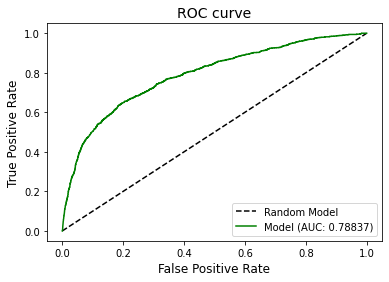

In [15]:
y_test_pred=xgbBest.predict_proba(X_test)[:, 1]
plot_auc_roc(y_test, y_test_pred)

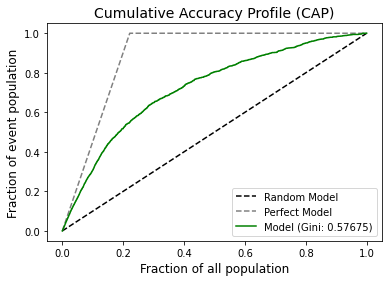

In [16]:
plot_cap(y_test, y_test_pred)

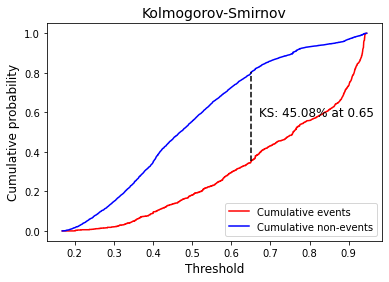

In [17]:
plot_ks(y_test, y_test_pred)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4670
           1       0.55      0.55      0.55      1330

    accuracy                           0.80      6000
   macro avg       0.71      0.71      0.71      6000
weighted avg       0.80      0.80      0.80      6000



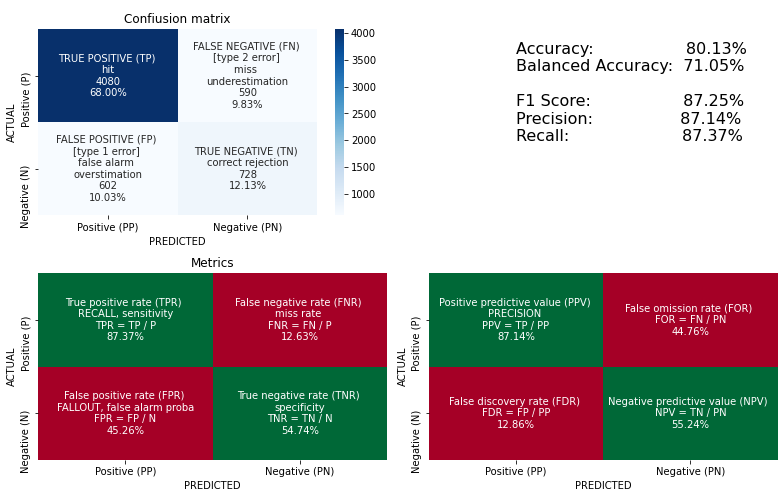

In [18]:
pred=np.where(y_test_pred>0.72,1,0)
cm = confusion_matrix(y_test, pred)
#cmd = ConfusionMatrixDisplay(cm, display_labels=['0','1'])
#cmd.plot()

print(classification_report(y_test, pred))
make_confusion_matrix2(cm, title='Test')

##### Future importance

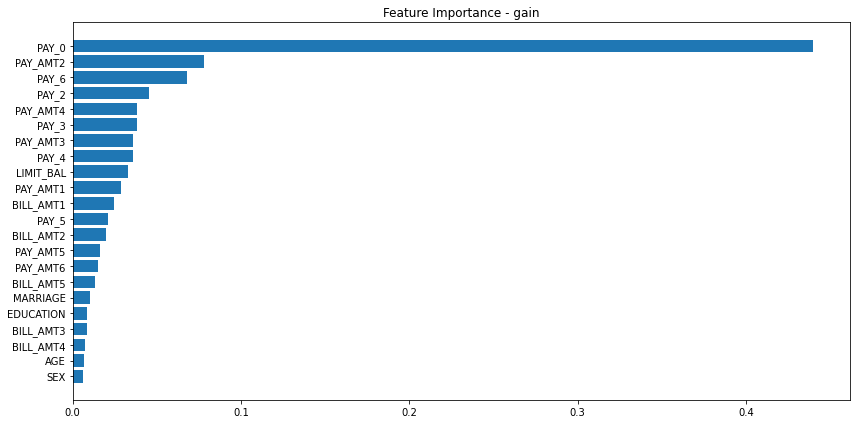

In [20]:
feature_important=xgbBest.get_booster().get_score(importance_type="gain")
f_importance=pd.DataFrame.from_dict(feature_important, orient='index',columns=['score'])
f_importance=f_importance/f_importance.sum()
f_importance.sort_values(by='score',ascending=True,inplace=True)
fig = plt.figure(figsize=(12, 6));
plt.barh(f_importance.index,f_importance.score);
plt.title("Feature Importance - gain");

#to samo ale tylko gain
# sorted_idx = xgbBest.feature_importances_.argsort()
# fig = plt.figure(figsize=(12, 6))
# plt.barh(np.array(X_test.columns)[sorted_idx], xgbBest.feature_importances_[sorted_idx])
# plt.title("Feature Importance - gain")

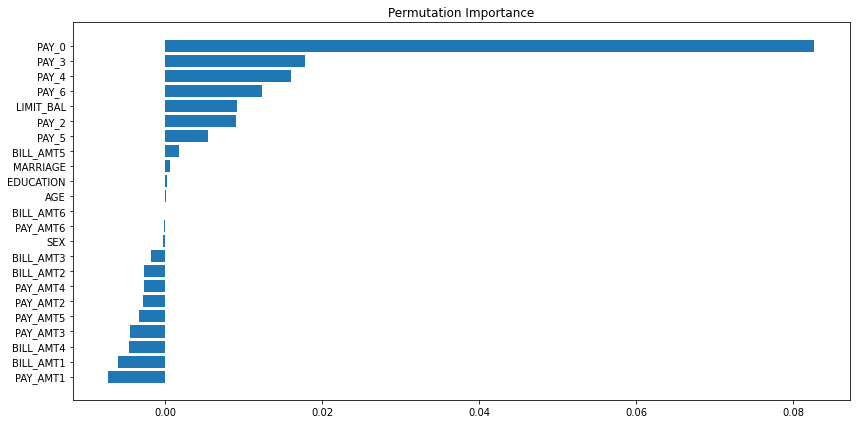

In [21]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(xgbBest, X_test, y_test
                                         , n_repeats=30
                                         , random_state=0)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6));
plt.barh(np.array(X_test.columns)[sorted_idx], perm_importance.importances_mean[sorted_idx]);
plt.title("Permutation Importance");

In [22]:
df = pd.DataFrame(list(zip(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])),
               columns =['Name', 'val'])
col_permut=df.loc[df.val>0,:].Name.to_list()
#df.loc[df.val>0,:]

In [23]:
X_train.loc[:,X_train.columns.isin(col_permut)]

LIMIT_BAL  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  \
5324     30000.0          2         1   38      0      0     -2     -2     -2   
14948   500000.0          2         2   30      1      0      0      0      0   
1631    100000.0          1         1   43     -1     -1     -1     -1     -1   
25767    90000.0          2         1   33      0      0      0      2      0   
5670    340000.0          2         1   40     -2     -2     -2     -2     -2   
...          ...        ...       ...  ...    ...    ...    ...    ...    ...   
4286     30000.0          3         2   22      0      0      0      0      0   
12069    80000.0          2         1   44      0      0      0      0      0   
27807   500000.0          2         2   29      0      0      0      0      0   
26994   400000.0          1         1   34     -1     -1     -2     -1     -1   
7240    180000.0          1         1   36     -2     -2     -2     -2     -2   

       PAY_6  BILL_AMT5  
5324      -2        0.0  
14948      0    46054.0  
1631      -1     8423.0  
25767      0    47804.0  
5670      -2        0.0  
...      ...        ...  
4286       0    19690.0  
12069      0    18531.0  
27807      0   316650.0  
26994     -1    17668.0  
7240      -2     5827.0  

[18000 rows x 11 columns]

In [24]:
xgbBest = XGBClassifier(**params_final)
xgbBest.fit(X_train.loc[:,X_train.columns.isin(col_permut)], y_train,early_stopping_rounds=40, 
            eval_set=[(X_train.loc[:,X_train.columns.isin(col_permut)],y_train),(X_test.loc[:,X_train.columns.isin(col_permut)],y_test)],verbose=50)  
measures = calculating_metrics(X_train.loc[:,X_train.columns.isin(col_permut)], 
                               X_test.loc[:,X_train.columns.isin(col_permut)], 
                               X_val.loc[:,X_train.columns.isin(col_permut)], 
                               y_train, y_test, y_val,xgbBest)
measures

[0]	validation_0-auc:0.73280	validation_1-auc:0.74447
[50]	validation_0-auc:0.77422	validation_1-auc:0.77963
[73]	validation_0-auc:0.77432	validation_1-auc:0.77972


AUC    GINI
TRAIN  0.7742  0.5484
TEST   0.7799  0.5597
OOT    0.7774  0.5548

Text(0.5, 1.0, 'Shap Importance')

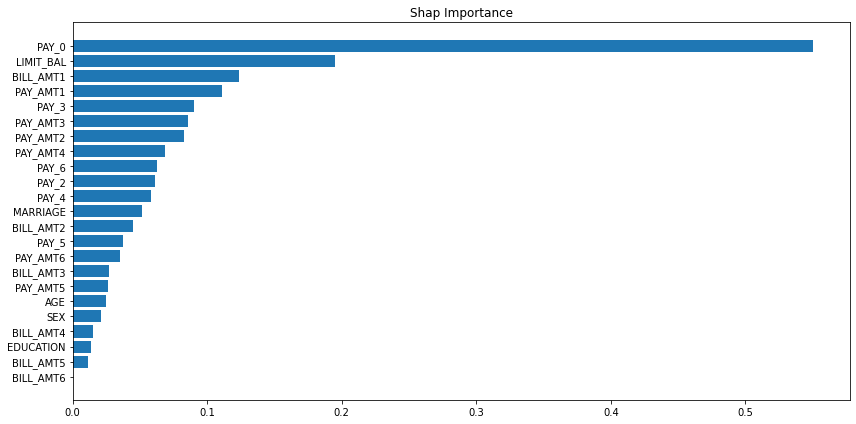

In [27]:
# explainer = shap.TreeExplainer(xgbBest)
# shap_values = explainer.shap_values(X_test)
#shap.summary_plot(shap_values, X_test, plot_type="bar")
explainer = shap.Explainer(xgbBest,feature_names=np.array(X_test.columns))
shap_values = explainer(np.ascontiguousarray(X_test))
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()

fig = plt.figure(figsize=(12, 6))
plt.barh(np.array(X_test.columns)[sorted_idx], shap_importance[sorted_idx])
plt.title("Shap Importance")

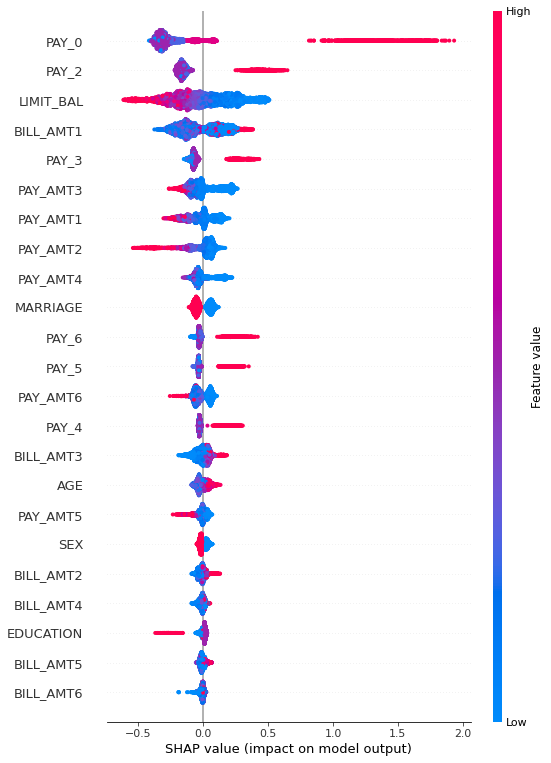

In [29]:
shap.plots.beeswarm(shap_values, max_display=30)

Text(0.5, 1.0, 'Feature Importance - weight')

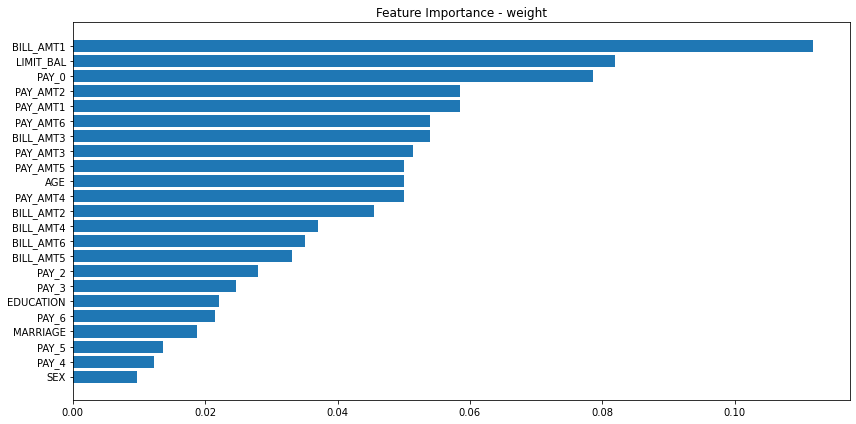

In [30]:
feature_important=xgbBest.get_booster().get_score(importance_type="weight")
f_importance=pd.DataFrame.from_dict(feature_important, orient='index',columns=['score'])
f_importance=f_importance/f_importance.sum()
f_importance.sort_values(by='score',ascending=True,inplace=True)
fig = plt.figure(figsize=(12, 6))
plt.barh(f_importance.index,f_importance.score)
plt.title("Feature Importance - weight")

Text(0.5, 1.0, 'Feature Importance - cover')

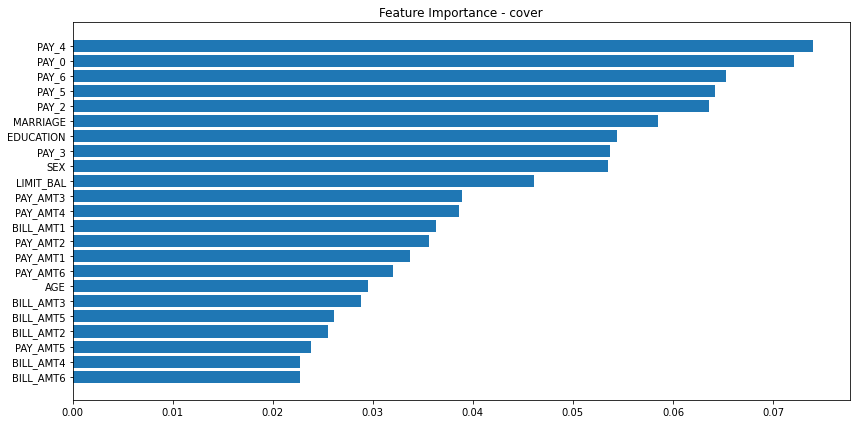

In [31]:
feature_important=xgbBest.get_booster().get_score(importance_type="cover")
f_importance=pd.DataFrame.from_dict(feature_important, orient='index',columns=['score'])
f_importance=f_importance/f_importance.sum()
f_importance.sort_values(by='score',ascending=True,inplace=True)
fig = plt.figure(figsize=(12, 6))
plt.barh(f_importance.index,f_importance.score)
plt.title("Feature Importance - cover")

##### model child - dotrenowanie

In [12]:
xgbBest2 = XGBClassifier()
xgbBest2.fit(X_val, y_val,early_stopping_rounds=20, eval_set=[(X_val,y_val)],verbose=50,xgb_model=xgbBest) 
measures = calculating_metrics(X_train, X_test, X_val, y_train, y_test, y_val,xgbBest2)
measures

[0]	validation_0-auc:0.79381
[50]	validation_0-auc:0.80791
[99]	validation_0-auc:0.81021


AUC    GINI
TRAIN  0.8083  0.6167
TEST   0.7891  0.5781
OOT    0.8102  0.6204

słaby efekt - spada moc na TEST

##### Kalibracja

https://github.com/MattiaCinelli/notebooks/blob/master/probability_calibration.ipynb

https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
   
przykład jak skalibrować   

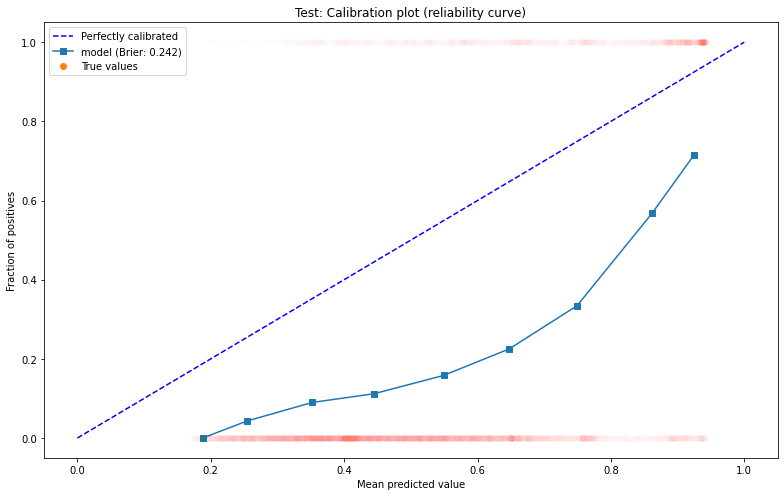

6000


In [28]:

import matplotlib.pyplot as plt
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LinearRegression

test_proba = xgbBest.predict_proba(X_test)[:, 1]

def plot_raw_calibration(y_test, test_proba,title):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated")
    ax.set_ylabel("Fraction of positives")
    ax.set_xlabel("Mean predicted value")
    ax.set_title(title+': Calibration plot (reliability curve)')
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, test_proba, n_bins=10)
    model_Brier_score = brier_score_loss(y_test, test_proba, pos_label=y.max())
    ax.plot(mean_predicted_value, fraction_of_positives, "s-",label="%s (Brier: %0.3f)" % ('model', model_Brier_score) )
    ax.plot(test_proba, y_test, 'o', alpha=.005, label="True values")
    ax.legend(loc="best",framealpha=.5)


    def update(handle, orig):
        handle.update_from(orig)
        handle.set_alpha(1)

    plt.legend(handler_map={PathCollection : HandlerPathCollection(update_func= update), plt.Line2D : HandlerLine2D(update_func = update)})

    plt.show()
    print(len(y_test))
    
plot_raw_calibration(y_test, test_proba,'Test')


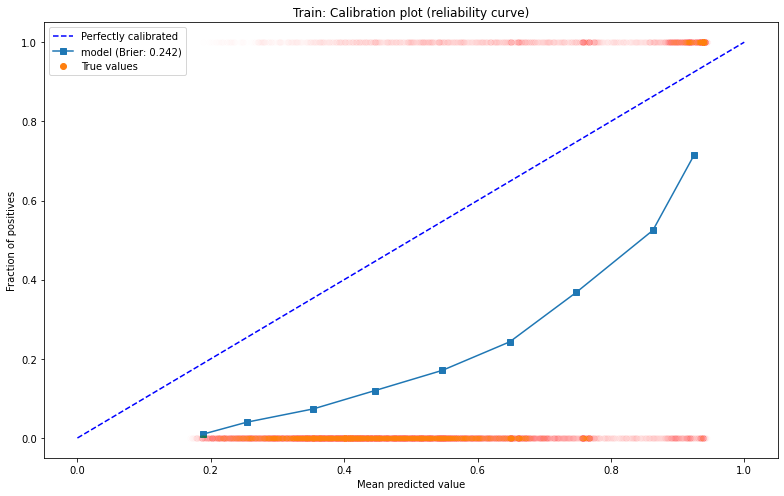

18000


In [29]:
train_proba = xgbBest.predict_proba(X_train)[:, 1]
plot_raw_calibration(y_train, train_proba,'Train')

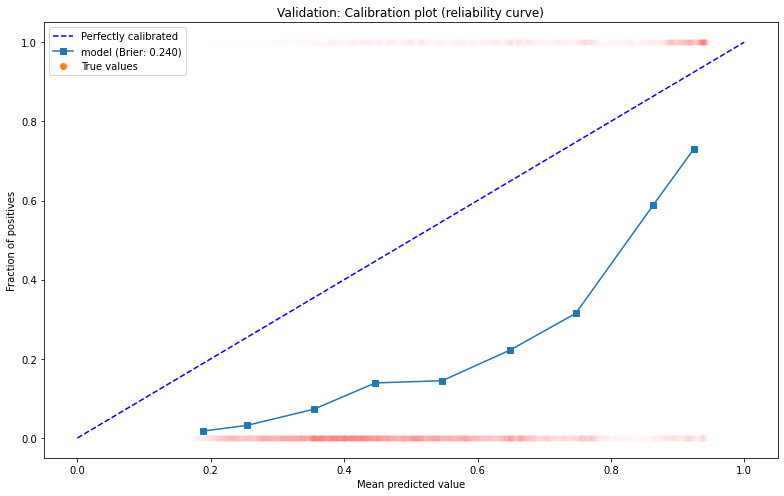

6000


In [30]:
val_proba = xgbBest.predict_proba(X_val)[:, 1]
plot_raw_calibration(y_val, val_proba,'Validation')

##### Proba to score

score min: -13.0, score max: 1315.0


dflt_ind  nondflt_ind  PD_init  score
25030         0            1   0.2832    718
5745          0            1   0.3293    702
2036          0            1   0.1826    759
21915         0            1   0.5534    636
20776         1            0   0.9185    476
...         ...          ...      ...    ...
14383         0            1   0.4229    673
20086         0            1   0.6160    617
23558         0            1   0.1895    756
12752         0            1   0.6338    611
7497          0            1   0.5122    647

[6000 rows x 4 columns]

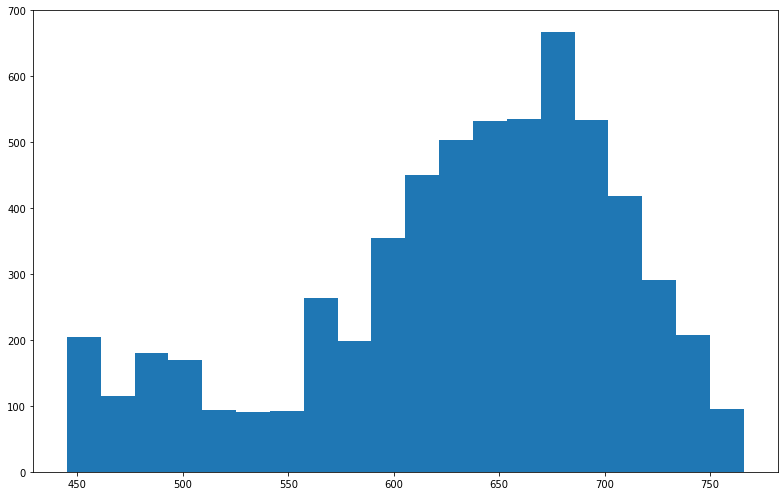

In [31]:
df=y_test.to_frame()
df.columns=['dflt_ind']
df['nondflt_ind']=1-df['dflt_ind']
df['PD_init'] = xgbBest.predict_proba(X_test)[:, 1]
pd_ref=df.loc[df.PD_init<=0.8,'PD_init'].mean()*0.7

s_min, s_max=pd_to_score2(df, 'PD_init', offset_start=700, PD_start=pd_ref,PDO=50 )
#df=df.sort_values(by='PD_init',ascending=True)
w=plt.hist(df.score,bins=20)
df

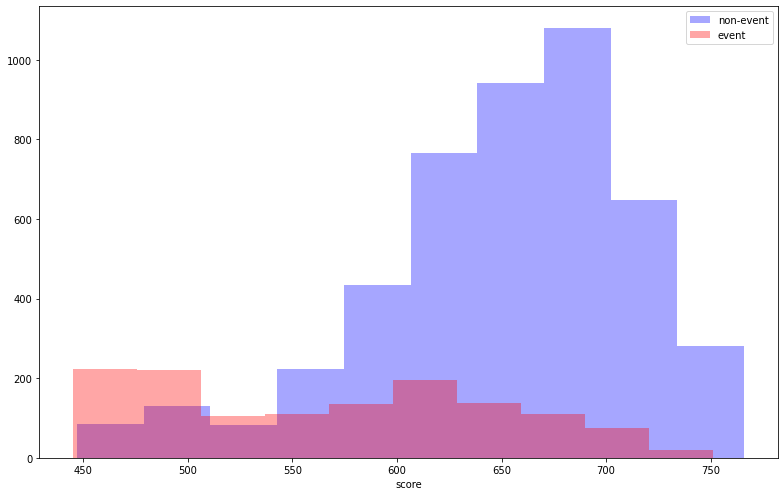

In [79]:

mask = y == 0
plt.hist(df.score[df.dflt_ind==0], label="non-event", color="b", alpha=0.35)
plt.hist(df.score[df.dflt_ind==1], label="event", color="r", alpha=0.35)
plt.xlabel("score")
plt.legend()
plt.show()

##### Kalibracja

###### kalibracja na predefiniowanej liczbie kubełków

Agregaty do kalibracji


dflt_ind_sum  nondflt_ind_sum  score_mean  PD_init_mean       odr  \
score                                                                      
0               566              298         488      0.900274  0.655093   
1               280              575         580      0.726136  0.327485   
2               166              699         619      0.609213  0.191908   
3               113              755         646      0.515552  0.130184   
4                89              778         672      0.429444  0.102653   
5                80              761         694      0.355775  0.095125   
6                36              804         729      0.255766  0.042857   

            odds  log_odds  PD_final  
score                                 
0       0.526502 -0.641501  0.650691  
1       2.053571  0.719580  0.316803  
2       4.210843  1.437663  0.204567  
3       6.681416  1.899330  0.146029  
4       8.741573  2.168090  0.103485  
5       9.512500  2.252607  0.076448  
6      22.333333  3.106080  0.046502


Parametry kalibracji -->alpha: 0.0151 , beta: -7.9982 , r-sqr: 0.9898


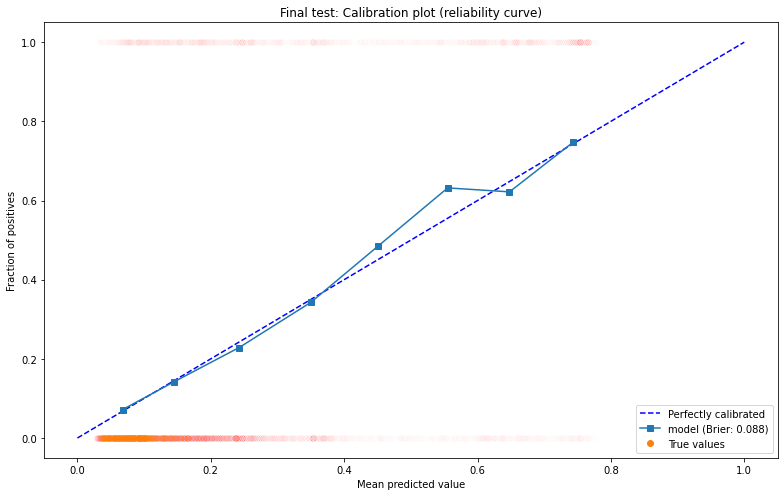

6000


In [42]:
#agregat do kalibracji
ile_grup=7
df_agg=df.groupby([pd.qcut(df['score'], ile_grup, labels=False)]
                    ).agg({'dflt_ind': ['sum'],'nondflt_ind': ['sum'],'score': ['mean'],'PD_init': ['mean']})
df_agg.columns=['_'.join(col).rstrip('_') for col in df_agg.columns.values]
#df.columns = df.columns.to_flat_index()
df_agg.score_mean=np.round(df_agg.score_mean,0).astype('int')
df_agg['odr']=df_agg['dflt_ind_sum']/(df_agg['dflt_ind_sum']+df_agg['nondflt_ind_sum'])
df_agg['odds']=df_agg['nondflt_ind_sum']/df_agg['dflt_ind_sum']
df_agg['log_odds']=np.log(df_agg['odds'])

#kalibracja
x=np.array(df_agg['score_mean']).reshape((-1, 1))
y=np.array(df_agg['log_odds'])
lg = LinearRegression()
lg.fit(x, y)
r_sq = lg.score(x, y)

df['PD_final']=1/(1+np.exp(lg.coef_[0]*df['score']+lg.intercept_))
df['log_odds_final']=lg.coef_[0]*df['score']+lg.intercept_

df_agg['PD_final']=1/(1+np.exp(lg.coef_[0]*df_agg['score_mean']+lg.intercept_))

print(f"Agregaty do kalibracji")
display(df_agg)
print(f"\nParametry kalibracji -->alpha: {lg.coef_[0]:0.4f} , beta: {lg.intercept_:0.4f} , r-sqr: {r_sq:0.4f}")
plot_raw_calibration(y_test, df['PD_final'],'Final test')


Po kalibracji


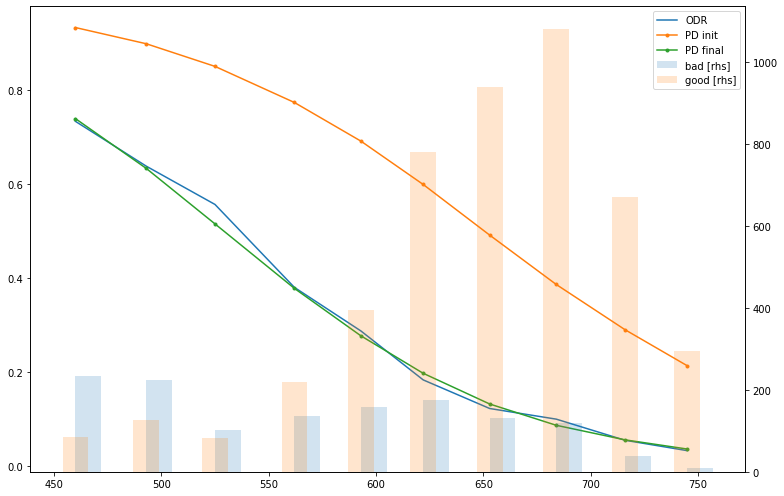

dflt_ind_sum  nondflt_ind_sum  score_mean  PD_init_mean  PD_final_mean  \
score                                                                           
0               234               85         460      0.933169       0.739352   
1               224              127         493      0.898680       0.633404   
2               103               82         525      0.850535       0.515393   
3               135              220         562      0.773727       0.378148   
4               159              394         593      0.691469       0.277151   
5               175              779         622      0.599285       0.197486   
6               131              938         653      0.491442       0.132116   
7               120             1081         684      0.386472       0.086836   
8                39              670         716      0.290341       0.055883   
9                10              294         745      0.213600       0.036318   

            odr       odds  log_odds  
score                                 
0      0.733542   0.363248 -1.012670  
1      0.638177   0.566964 -0.567459  
2      0.556757   0.796117 -0.228010  
3      0.380282   1.629630  0.488353  
4      0.287523   2.477987  0.907447  
5      0.183438   4.451429  1.493225  
6      0.122544   7.160305  1.968553  
7      0.099917   9.008333  2.198150  
8      0.055007  17.179487  2.843716  
9      0.032895  29.400000  3.380995

In [41]:
df_agg=df.groupby([pd.cut(df['score'], 10, labels=False)]
                    ).agg({'dflt_ind': ['sum'],'nondflt_ind': ['sum'],'score': ['mean'],
                           'PD_init': ['mean'],'PD_final': ['mean']})
df_agg.columns=['_'.join(col).rstrip('_') for col in df_agg.columns.values]
#df.columns = df.columns.to_flat_index()
df_agg.score_mean=np.round(df_agg.score_mean,0).astype('int')
df_agg['odr']=df_agg['dflt_ind_sum']/(df_agg['dflt_ind_sum']+df_agg['nondflt_ind_sum'])
df_agg['odds']=df_agg['nondflt_ind_sum']/df_agg['dflt_ind_sum']
df_agg['log_odds']=np.log(df_agg['odds'])

print(f"\nPo kalibracji")

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(df_agg.score_mean,df_agg.odr , "-",label="ODR" )
ax.plot(df_agg.score_mean,df_agg.PD_init_mean , ".-",label="PD init" )
ax.plot(df_agg.score_mean,df_agg.PD_final_mean , ".-",label="PD final" )
ax2 = ax.twinx()
ax2.bar(df_agg.score_mean,df_agg.dflt_ind_sum ,label="bad [rhs]",align='edge', width=12,alpha=0.2 )
ax2.bar(df_agg.score_mean,df_agg.nondflt_ind_sum ,label="good [rhs]",align='center', width=12,alpha=0.2 )
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()


display(df_agg)

###### kalibracja po wybraniu liczby kubełków z optbining

'OPTIMAL'

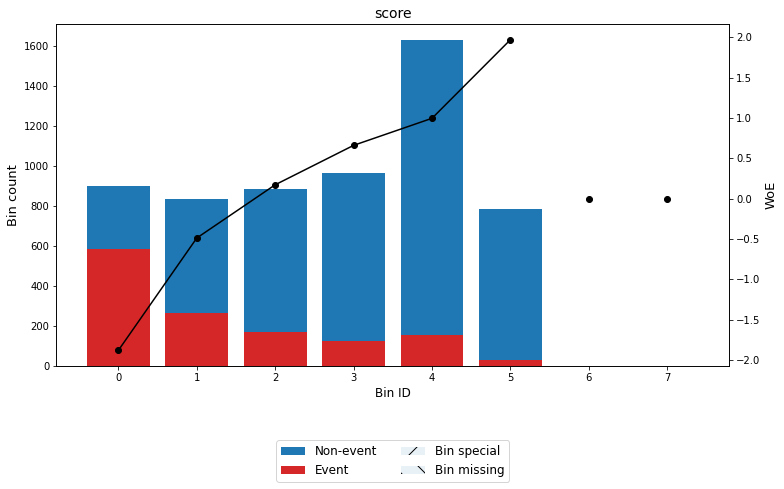

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 549.50)    898   0.149667        313    585    0.651448   
1       [549.50, 604.50)    836   0.139333        571    265    0.316986   
2       [604.50, 634.50)    884   0.147333        713    171    0.193439   
3       [634.50, 663.50)    967   0.161167        843    124    0.128232   
4       [663.50, 709.50)   1629   0.271500       1474    155    0.095150   
5          [709.50, inf)    786   0.131000        756     30    0.038168   
6                Special      0   0.000000          0      0    0.000000   
7                Missing      0   0.000000          0      0    0.000000   
Totals                     6000   1.000000       4670   1330    0.221667   

             WoE        IV        JS  
0      -1.881389  0.701431  0.076676  
1      -0.488321  0.037590  0.004653  
2       0.171838  0.004142  0.000517  
3       0.660705  0.057667  0.007080  
4        0.99633  0.198360  0.023818  
5       1.970864  0.274596  0.029665  
6            0.0  0.000000  0.000000  
7            0.0  0.000000  0.000000  
Totals            1.273786  0.142408

array([549.5, 604.5, 634.5, 663.5, 709.5])

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.57052068
    IV (Jeffrey)             1.27378611
    JS (Jensen-Shannon)      0.14240807
    Hellinger                0.15016198
    Triangular               0.51951852
    KS                       0.44980438
    HHI                      0.18036894
    HHI (normalized)         0.06327879
    Cramer's V               0.47661436
    Quality score            0.02772997

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic      p-value  P[A > B]     P[B > A]
        0      1   193.800156 4.708485e-44  1.000000 1.110223e-16
        1      2    34.657561 3.931087e-09  1.000000 3.218703e-11
        2      3    14.657017 1.289537e-04  0.999965 3.525998e-05
        3      4     6.922863 8.510065e-03  0.995574 4.425896e-03
        4      5    24.336973 8.087179e-07  1.00

In [43]:
variable='score'
x=df[variable].values
y=df['dflt_ind'].values
optb = OptimalBinning(name=variable 
                      ,dtype="numerical" 
                      ,solver="cp"
                      #,max_pvalue =0.2 #mocno wpływa - doczytać dokumentację
                      ,prebinning_method ='cart' # cart / mdlp / quantile / uniform
                      ,min_prebin_size =0.02
                      ,min_bin_size=0.1
                      #,monotonic_trend ='auto_asc_desc'
                      ,gamma=0.1 #ogranicznie koncentracji bucket'ów [regularyzacja]
                      ,outlier_detector ='zscore'
                     )
optb.fit(x, y)
display(optb.status)
binning_table = optb.binning_table
btable=binning_table.build()
binning_table.plot(metric="woe")
#binning_table.plot(metric="event_rate")
display(btable)
display(optb.splits)
optb.binning_table.analysis()


Agregaty do kalibracji


dflt_ind_sum  nondflt_ind_sum  score_mean  PD_init_mean       odr  \
score                                                                      
0.0             265              571         582      0.721496  0.316986   
1.0             171              713         620      0.606452  0.193439   
2.0             124              843         649      0.506955  0.128232   
3.0             155             1474         685      0.384639  0.095150   

           odds  log_odds  PD_final  
score                                
0.0    2.154717  0.767659  0.303452  
1.0    4.169591  1.427818  0.199976  
2.0    6.798387  1.916685  0.140589  
3.0    9.509677  2.252310  0.088128


Parametry kalibracji -->alpha: 0.0146 , beta: -7.6775 , r-sqr: 0.9807


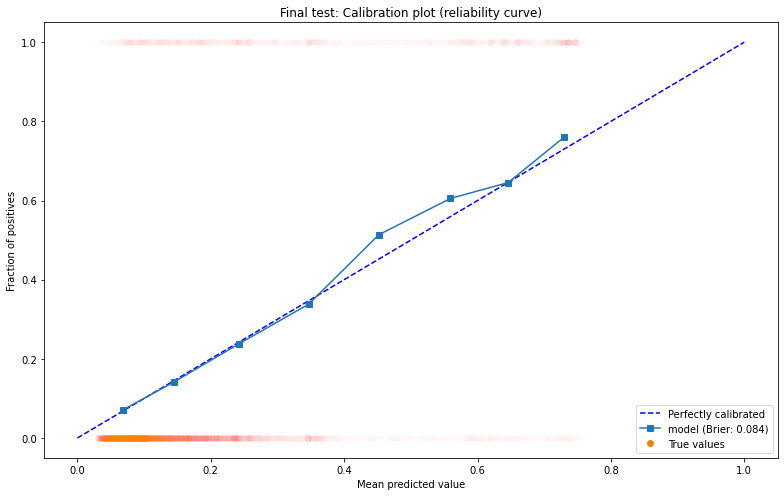

6000


In [52]:
#kalibracja z opt bining

df_agg=df.groupby([pd.cut(df['score'], list(optb.splits), labels=False)]
                    ).agg({'dflt_ind': ['sum'],'nondflt_ind': ['sum'],'score': ['mean'],'PD_init': ['mean']})
df_agg.columns=['_'.join(col).rstrip('_') for col in df_agg.columns.values]
#df.columns = df.columns.to_flat_index()
df_agg.score_mean=np.round(df_agg.score_mean,0).astype('int')
df_agg['odr']=df_agg['dflt_ind_sum']/(df_agg['dflt_ind_sum']+df_agg['nondflt_ind_sum'])
df_agg['odds']=df_agg['nondflt_ind_sum']/df_agg['dflt_ind_sum']
df_agg['log_odds']=np.log(df_agg['odds'])

#kalibracja
x=np.array(df_agg['score_mean']).reshape((-1, 1))
y=np.array(df_agg['log_odds'])
lg = LinearRegression()
lg.fit(x, y)
r_sq = lg.score(x, y)

df['PD_final']=1/(1+np.exp(lg.coef_[0]*df['score']+lg.intercept_))
df['log_odds_final']=lg.coef_[0]*df['score']+lg.intercept_

df_agg['PD_final']=1/(1+np.exp(lg.coef_[0]*df_agg['score_mean']+lg.intercept_))

print(f"Agregaty do kalibracji")
display(df_agg)
print(f"\nParametry kalibracji -->alpha: {lg.coef_[0]:0.4f} , beta: {lg.intercept_:0.4f} , r-sqr: {r_sq:0.4f}")
plot_raw_calibration(y_test, df['PD_final'],'Final test')


Po kalibracji


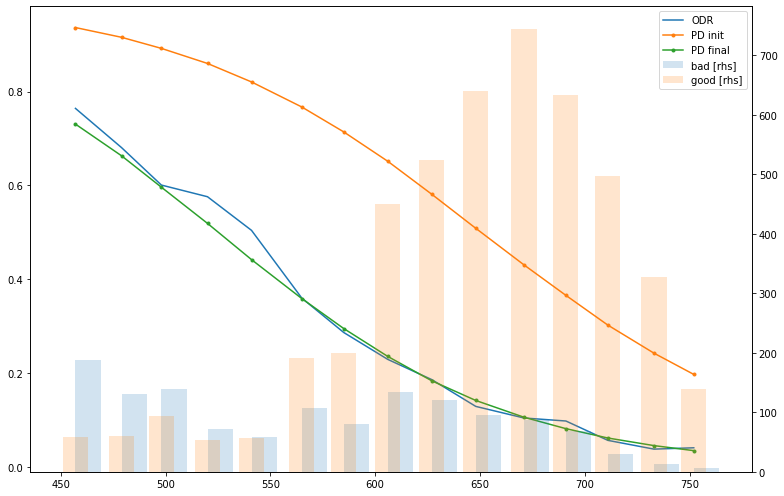

dflt_ind_sum  nondflt_ind_sum  score_mean  PD_init_mean  PD_final_mean  \
score                                                                           
0               188               58         457      0.936453       0.730716   
1               130               61         479      0.915683       0.663192   
2               140               93         498      0.892080       0.596292   
3                72               53         520      0.859978       0.519206   
4                58               57         541      0.820589       0.442023   
5               108              192         565      0.767190       0.359014   
6                80              199         585      0.714125       0.295184   
7               134              450         606      0.651579       0.235770   
8               120              524         627      0.581269       0.183800   
9                95              640         648      0.508724       0.141892   
10               87              745         671      0.430788       0.106182   
11               69              634         691      0.365828       0.081846   
12               30              497         711      0.302520       0.061917   
13               13              327         733      0.242739       0.045753   
14                6              140         752      0.197446       0.034996   

            odr       odds  log_odds  
score                                 
0      0.764228   0.308511 -1.175999  
1      0.680628   0.469231 -0.756661  
2      0.600858   0.664286 -0.409043  
3      0.576000   0.736111 -0.306374  
4      0.504348   0.982759 -0.017392  
5      0.360000   1.777778  0.575364  
6      0.286738   2.487500  0.911278  
7      0.229452   3.358209  1.211408  
8      0.186335   4.366667  1.474000  
9      0.129252   6.736842  1.907591  
10     0.104567   8.563218  2.147476  
11     0.098151   9.188406  2.217942  
12     0.056926  16.566667  2.807393  
13     0.038235  25.153846  3.225011  
14     0.041096  23.333333  3.149883

In [54]:
df_agg=df.groupby([pd.cut(df['score'], 15, labels=False)]
                    ).agg({'dflt_ind': ['sum'],'nondflt_ind': ['sum'],'score': ['mean'],
                           'PD_init': ['mean'],'PD_final': ['mean']})
df_agg.columns=['_'.join(col).rstrip('_') for col in df_agg.columns.values]
#df.columns = df.columns.to_flat_index()
df_agg.score_mean=np.round(df_agg.score_mean,0).astype('int')
df_agg['odr']=df_agg['dflt_ind_sum']/(df_agg['dflt_ind_sum']+df_agg['nondflt_ind_sum'])
df_agg['odds']=df_agg['nondflt_ind_sum']/df_agg['dflt_ind_sum']
df_agg['log_odds']=np.log(df_agg['odds'])

print(f"\nPo kalibracji")

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(df_agg.score_mean,df_agg.odr , "-",label="ODR" )
ax.plot(df_agg.score_mean,df_agg.PD_init_mean , ".-",label="PD init" )
ax.plot(df_agg.score_mean,df_agg.PD_final_mean , ".-",label="PD final" )
ax2 = ax.twinx()
ax2.bar(df_agg.score_mean,df_agg.dflt_ind_sum ,label="bad [rhs]",align='edge', width=12,alpha=0.2 )
ax2.bar(df_agg.score_mean,df_agg.nondflt_ind_sum ,label="good [rhs]",align='center', width=12,alpha=0.2 )
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()


display(df_agg)

##### Mapping rating

In [55]:
df['PD_rating']= (optb.transform(df[variable].values, metric="indices").astype(str) )
df['PD_rating']='K'+df['PD_rating']
df_agg=df.groupby(df['PD_rating']).agg({'score': ['min','max','mean'],'PD_final': ['min','max','mean']})
df_agg

score                   PD_final                    
            min  max        mean       min       max      mean
PD_rating                                                     
K0          445  549  490.596882  0.413752  0.763495  0.619381
K1          550  604  581.575359  0.240026  0.410211  0.306843
K2          605  634  619.677602  0.169227  0.237369  0.201544
K3          635  663  648.987590  0.117629  0.167181  0.141245
K4          664  709  685.133824  0.063711  0.116120  0.089097
K5          710  766  730.139949  0.028724  0.062844  0.048432

##### Strategy curve

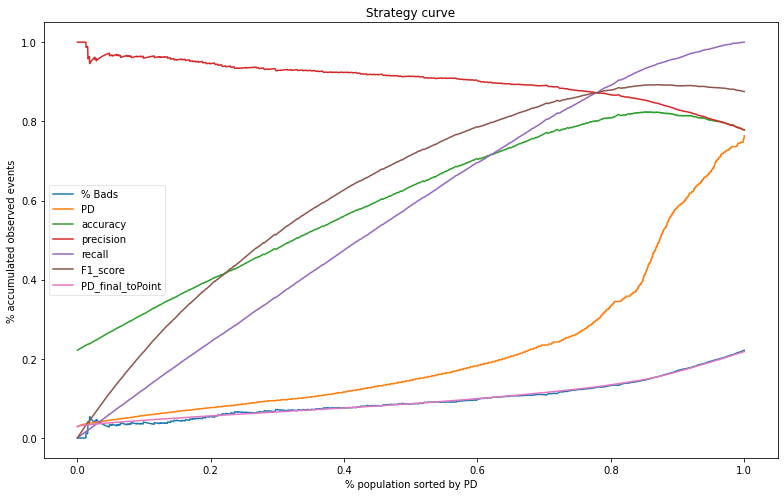

In [76]:
df_sorted=df.sort_values(by=['score','dflt_ind'],ascending=[False, True])
#df_sorted=df.sort_values(by=['score'],ascending=False)
df_sorted['dflt_ind_cumsum']=df_sorted['dflt_ind'].cumsum()
df_sorted['nondflt_ind_cumsum']=df_sorted['nondflt_ind'].cumsum()
df_sorted['pct_population']=(df_sorted['dflt_ind_cumsum']+df_sorted['nondflt_ind_cumsum'])/df_sorted.shape[0]
df_sorted['pct_event']=df_sorted['dflt_ind_cumsum']/(df_sorted['dflt_ind_cumsum']+df_sorted['nondflt_ind_cumsum'])
df_sorted['TP']=df_sorted['nondflt_ind_cumsum']
df_sorted['FP']=df_sorted['dflt_ind_cumsum']
df_sorted['FN']=df_sorted['nondflt_ind_cumsum'].iloc[-1]-df_sorted['nondflt_ind_cumsum']
df_sorted['TN']=df_sorted['dflt_ind_cumsum'].iloc[-1]-df_sorted['dflt_ind_cumsum']
df_sorted['accuracy']=(df_sorted.TP+df_sorted.TN)/(df_sorted.TP+df_sorted.FP+df_sorted.FN+df_sorted.TN)
df_sorted['precision']=df_sorted.TP/(df_sorted.TP+df_sorted.FP)
df_sorted['recall']=df_sorted.TP/(df_sorted.TP+df_sorted.FN)
df_sorted['F1_score']=2*df_sorted.TP/(2*df_sorted.TP+df_sorted.FP+df_sorted.FN)
df_sorted['PD_final_toPoint']=df_sorted['PD_final'].cumsum()/(df_sorted['dflt_ind_cumsum']+df_sorted['nondflt_ind_cumsum'])
fig = plt.figure()
ax = fig.add_subplot()

ax.plot(df_sorted['pct_population'],df_sorted['pct_event'] , "-",label="% Bads" )
ax.plot(df_sorted['pct_population'],df_sorted['PD_final'] , "-",label="PD" )
ax.plot(df_sorted['pct_population'],df_sorted['accuracy'] , "-",label="accuracy" )
ax.plot(df_sorted['pct_population'],df_sorted['precision'] , "-",label="precision" )
ax.plot(df_sorted['pct_population'],df_sorted['recall'] , "-",label="recall" )
ax.plot(df_sorted['pct_population'],df_sorted['F1_score'] , "-",label="F1_score" )
ax.plot(df_sorted['pct_population'],df_sorted['PD_final_toPoint'] , "-",label="PD_final_toPoint" )
#ax.plot(df_sorted['pct_population'],df_sorted['pct_population'] , "-",label="% population" )
ax.legend(loc="best",framealpha=.5)
plt.title('Strategy curve')
plt.ylabel('% accumulated observed events')
plt.xlabel('% population sorted by PD')
plt.show()

https://campus.datacamp.com/courses/credit-risk-modeling-in-r/chapter-4-evaluating-a-credit-risk-model?ex=1 


In [62]:
pd.options.plotting.backend = "plotly" #zmiana domyślnego wykresu DataFrame na plotly

In [139]:
Y=['precision','recall','F1_score','PD_final','accuracy','PD_final_toPoint','pct_event']
fig = df_sorted.plot(x='pct_population'\
               , y=Y\
               ,labels={
                    "variable": "Legend",
                    "pct_population": "% population sorted by PD",
                    "value": "% of metric",
                    "pct_event": "% Bad",    
                }
                ,title="Strategy curve"
              )
fig.data[Y.index('pct_event')].name="% Bads"
fig.data[Y.index('PD_final')].line.color = "Black"
fig.data[Y.index('PD_final')].line.width = 4
fig.update_layout( plot_bgcolor="rgba(0,0,0,0)") #per_bgcolor="rgba(0,0,0,0)", 
fig.update_xaxes(showline=True, linewidth=.1, linecolor='black', gridcolor='LightGrey')
fig.update_yaxes(showline=True, linewidth=.1, linecolor='black', gridcolor='LightGrey')
fig.layout.xaxis.tickformat = '.0%'
fig.layout.yaxis.tickformat = '.0%'
fig.show()

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4670
           1       0.58      0.52      0.55      1330

    accuracy                           0.81      6000
   macro avg       0.72      0.71      0.71      6000
weighted avg       0.80      0.81      0.81      6000



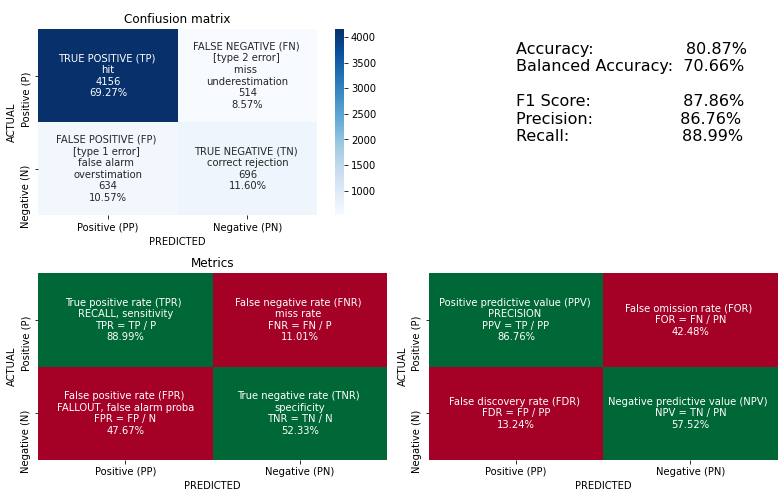

In [83]:
pred=np.where(df.PD_final>0.33,1,0)
cm = confusion_matrix(y_test, pred)
#cmd = ConfusionMatrixDisplay(cm, display_labels=['0','1'])
#cmd.plot()

print(classification_report(y_test, pred))
make_confusion_matrix2(cm, title='Test')

In [334]:
df_sorted.iloc[4100:4110,:]

dflt_ind  nondflt_ind  PD_init  score  PD_final  log_odds_final  \
17063         1            0   0.7606    589  0.227757         1.22102   
14030         1            0   0.7590    589  0.227757         1.22102   
28552         1            0   0.7602    589  0.227757         1.22102   
26            1            0   0.7598    589  0.227757         1.22102   
15617         0            1   0.7625    588  0.230385         1.20614   
5591          0            1   0.7625    588  0.230385         1.20614   
5059          0            1   0.7621    588  0.230385         1.20614   
7230          0            1   0.7630    588  0.230385         1.20614   
19830         0            1   0.7614    588  0.230385         1.20614   
8804          0            1   0.7633    588  0.230385         1.20614   

      PD_rating  dflt_ind_cumsum  nondflt_ind_cumsum  pct_population  \
17063        K2              445                3656        0.683500   
14030        K2              446                3656        0.683667   
28552        K2              447                3656        0.683833   
26           K2              448                3656        0.684000   
15617        K2              448                3657        0.684167   
5591         K2              448                3658        0.684333   
5059         K2              448                3659        0.684500   
7230         K2              448                3660        0.684667   
19830        K2              448                3661        0.684833   
8804         K2              448                3662        0.685000   

       pct_event    TP   FP    FN   TN  accuracy  precision    recall  \
17063   0.108510  3656  445  1014  885  0.756833   0.891490  0.782869   
14030   0.108727  3656  446  1014  884  0.756667   0.891273  0.782869   
28552   0.108945  3656  447  1014  883  0.756500   0.891055  0.782869   
26      0.109162  3656  448  1014  882  0.756333   0.890838  0.782869   
15617   0.109135  3657  448  1013  882  0.756500   0.890865  0.783084   
5591    0.109109  3658  448  1012  882  0.756667   0.890891  0.783298   
5059    0.109082  3659  448  1011  882  0.756833   0.890918  0.783512   
7230    0.109056  3660  448  1010  882  0.757000   0.890944  0.783726   
19830   0.109029  3661  448  1009  882  0.757167   0.890971  0.783940   
8804    0.109002  3662  448  1008  882  0.757333   0.890998  0.784154   

       F1_score  
17063  0.833656  
14030  0.833561  
28552  0.833466  
26     0.833371  
15617  0.833504  
5591   0.833637  
5059   0.833770  
7230   0.833903  
19830  0.834036  
8804   0.834169